# Atividade: Gerando Dados Sintéticos Realistas

## Objetivo
Gerar um dataset sintético simulando logs de acesso a um e-commerce, definindo variáveis, distribuições e avaliando a qualidade dos dados.

### Passo 1: Definição das Variáveis e Dicionário de Dados (2 pontos)

Crie um dicionário para as variáveis do seu DataFrame. O DataFrame deve incluir variáveis contínuas, categóricas e com valores nulos.  
O dicionário de dados deve incluir 'nome da variável', 'tipo' e 'descrição'.

| Variável          | Tipo      | Descrição                              | Distribuição Sugerida          |
|-------------------|-----------|----------------------------------------|--------------------------------|
| session_id        | String    | ID único da sessão                     | UUID ou sequência numérica     |
| user_id           | Integer   | ID do usuário                          | Sequência numérica - 10% não logados (Null)   |
| timestamp         | Datetime  | Timestamp do evento                    | Distribuição temporal diária (Poisson)  |
| page_url          | String    | URL da página acessada                 | Padrão `/produto/{id}`         |
| session_duration  | Float     | Duração da sessão em segundos          | Exponencial                    |
| add_to_cart       | Boolean   | Indicador de adicionar ao carrinho     | Bernoulli(p=0.2)               |
| purchase          | Boolean   | Indicador de compra                    | Bernoulli(p=0.05)              |

### Passo 2: Geração do Dataset em Python Básico (3 pontos)

Gere o dataset utilizando apenas bibliotecas como `numpy`, `pandas` e `datetime` (sem bibliotecas como `Faker`).

**Desafios extras**:  
- Adicionar dependências entre variáveis (ex: `session_duration` maior para `add_to_cart`).  
- Gerar URLs realistas (ex: `/produto/{id}` com `id` sequencial).  
- Considerar períodos de alta sazonalidade como natal, dia das mães e Black Friday.

#### 2.1 Instalação das dependências

In [20]:
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


#### 2.2 Importando bibliotecas

In [21]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#### 2.3 Definindo o período e gerando datas com sazonalidade

O período contemplado será de todos os dias do ano de 2024

In [22]:
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
days = pd.date_range(start_date, end_date, freq='D')

#### 2.4 Gerando timestamps de sessões diárias com variação sazonal

Aqui será gerado os numéros de sessões por dia com variação no Natal e na black friday, a fim de gerar os ruídos similares aos encontrados em datasets reais. No natal haverá 30% mais visitas, já na black friday as visitas dobrarão


In [23]:
sessions = []
base_sessions = 300

for day in days:
    n = np.random.poisson(base_sessions)
    # Natal
    if day.month == 12 and 20 <= day.day <= 24:
        n = int(n * 1.3)

    # Black Friday
    if day.month == 11 and day.weekday() == 4 and day.day >= 23:
        n = int(n * 2)
    for _ in range(n):
        random_time = day + timedelta(
            hours=np.random.randint(0, 24),
            minutes=np.random.randint(0, 60),
            seconds=np.random.randint(0, 60)
        )
        sessions.append(random_time)

timestamps = sessions

#### 2.5 Construindo DataFrame inicial com timestamp e IDs

Inicia as outras colunas do dataframe, como session_id, user_id, product_id e page_url

In [24]:
df = pd.DataFrame({'timestamp': timestamps})
df['session_id'] = ['sess_' + str(i) for i in range(len(df))]
df['user_id'] = np.random.randint(1, 10000, size=len(df))
df['product_id'] = np.random.randint(1, 1000, size=len(df))
df['page_url'] = df['product_id'].apply(lambda x: f"/produto/{x}")

#### 2.6 Adicionando variáveis de comportamento

Adiciona a coluna `add_to_cart` com 20% de probabilidade de ser verdadeira

In [25]:
# add_to_cart com probabilidade 0.2
df['add_to_cart'] = np.random.rand(len(df)) < 0.2

##### Ajustando session_duration conforme `add_to_cart`

Gera o tempo de sessão e aumenta em 50% o tempo de sessão em que `add_to_cart` é `true`

In [26]:
# Duração exponencial
df['session_duration'] = np.random.exponential(scale=300, size=len(df))
# Aumenta duração em sessões com add_to_cart
df.loc[df['add_to_cart'], 'session_duration'] *= 1.5

##### Definindo `purchase` dependente de `add_to_cart`

Adiciona a coluna `purchase`. Ela tem 20% de chance de ser verdadeira se a coluna `add_to_cart` é verdadeira

In [27]:
purchase_prob = np.where(df['add_to_cart'], 0.2, 0.0)
df['purchase'] = np.random.rand(len(df)) < purchase_prob

##### Inserindo valores nulos

Insere valor nulo em `user_id` para representar usuários não logados. A probabilidade do usuário ser nulo é de 10%

In [28]:
mask = np.random.rand(len(df)) < 0.1
df.loc[mask, 'user_id'] = pd.NA
df.isnull().sum()

timestamp               0
session_id              0
user_id             10953
product_id              0
page_url                0
add_to_cart             0
session_duration        0
purchase                0
dtype: int64

##### Versão final do Dataset

In [29]:
df.head()

,timestamp,session_id,user_id,product_id,page_url,add_to_cart,session_duration,purchase
0,2024-01-01 02:18:02,sess_0,3933.0,157,/produto/157,True,559.556219,False
1,2024-01-01 20:11:07,sess_1,8322.0,768,/produto/768,False,1132.147897,False
2,2024-01-01 20:24:04,sess_2,6213.0,513,/produto/513,False,686.833808,False
3,2024-01-01 10:42:50,sess_3,NaN,905,/produto/905,False,71.553465,False
4,2024-01-01 06:32:24,sess_4,2311.0,763,/produto/763,False,225.594131,False


Tamanho do DF

In [30]:
len(df)

110136

### Passo 3: Avaliação da Qualidade dos Dados (3 pontos)

**Dica**  
- Capriche na visualização dos dados (i.e., use os gráficos certos para demonstrar o seu ponto)

#### 3.1 Estatísticas e valores ausentes

In [31]:
# Percentual de valores ausentes
missing = df.isnull().mean() * 100
print(missing)

# Estatísticas descritivas
df.describe()

timestamp           0.000000
session_id          0.000000
user_id             9.944977
product_id          0.000000
page_url            0.000000
add_to_cart         0.000000
session_duration    0.000000
purchase            0.000000
dtype: float64


,timestamp,user_id,product_id,session_duration
count,110136,99183.000000,110136.000000,110136.000000
mean,2024-07-03 08:47:50.114685440,5015.767379,500.803588,331.717705
min,2024-01-01 00:10:13,1.000000,1.000000,0.002487
25%,2024-04-02 04:49:35.249999872,2521.000000,251.000000,92.664607
50%,2024-07-03 08:12:28,5024.000000,501.000000,226.417732
75%,2024-10-03 10:36:04.249999872,7521.000000,752.000000,454.738015
max,2024-12-31 23:59:43,9999.000000,999.000000,4895.857243
std,NaN,2886.218457,288.473470,342.520491


#### 3.2 Visualizações

##### Histograma da duração da sessão

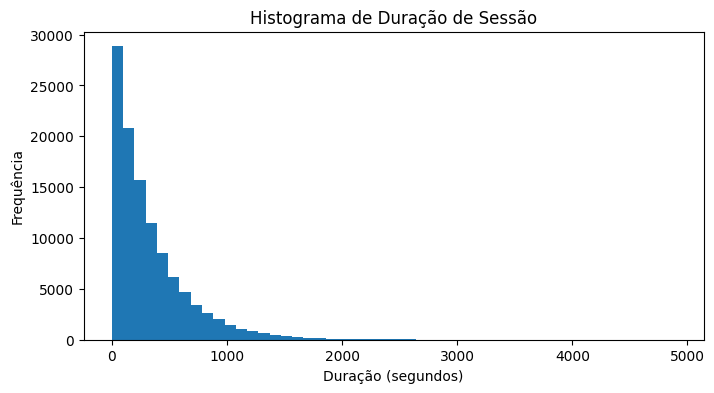

In [32]:
# Histograma de duração de sessão
plt.figure(figsize=(8,4))
plt.hist(df['session_duration'], bins=50)
plt.title('Histograma de Duração de Sessão')
plt.xlabel('Duração (segundos)')
plt.ylabel('Frequência')
plt.show()

A duração da sessão é representada por uma distribuição poisson

##### Relação entre a quantidade de `add_to_cart` vs `purchase`

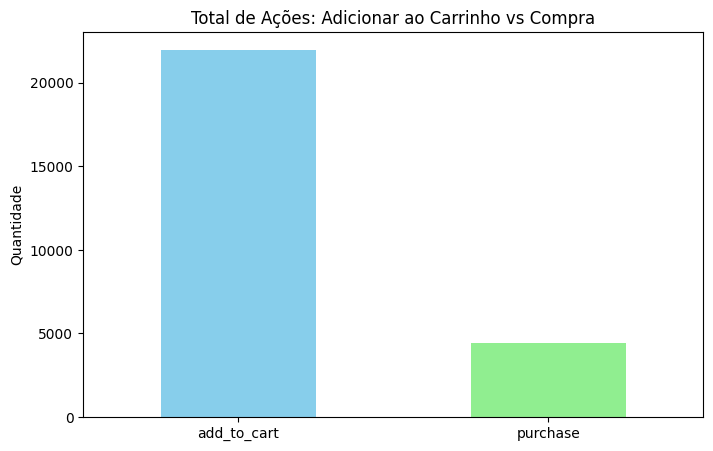

In [33]:
# Calculando os totais
totals = df[['add_to_cart', 'purchase']].sum()

# Criando o gráfico
plt.figure(figsize=(8,5))
totals.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Total de Ações: Adicionar ao Carrinho vs Compra')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

Dado que `purchase` só ocorre se `add_to_cart` for verdadeiro, faz sentido a correlação demonstrada

##### Quantidade de sessões por dia

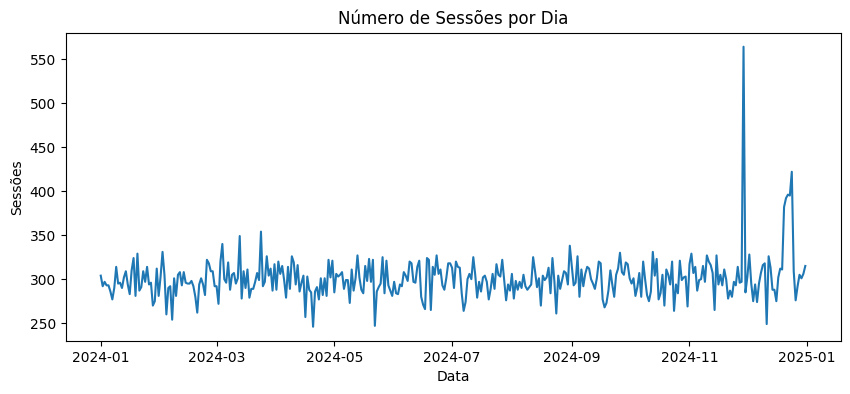

In [34]:
daily_counts = df.set_index('timestamp').resample('D').size()
plt.figure(figsize=(10,4))
plt.plot(daily_counts.index, daily_counts.values)
plt.title('Número de Sessões por Dia')
plt.xlabel('Data')
plt.ylabel('Sessões')
plt.show()

A partir disso, é possível ver o aumento realizado entre o número de sessões na black friday e no natal

#### 3.3 Boxplot da duração de sessão por add_to_cart
Este gráfico compara a distribuição do tempo de sessão entre sessões que resultaram em adição ao carrinho e as que não resultaram, permitindo visualizar a dispersão e possíveis outliers.

<Figure size 800x400 with 0 Axes>

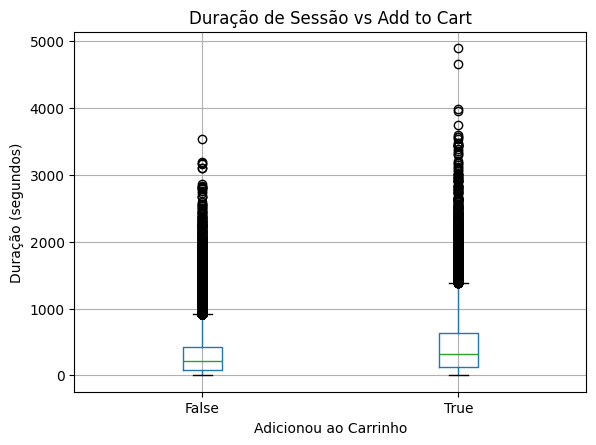

In [35]:
# Boxplot de duration por add_to_cart
plt.figure(figsize=(8,4))
df.boxplot(column='session_duration', by='add_to_cart')
plt.title('Duração de Sessão vs Add to Cart')
plt.suptitle('')
plt.xlabel('Adicionou ao Carrinho')
plt.ylabel('Duração (segundos)')
plt.show()

A partir desse gráfico, fica visível a quantidade de outliers não esperados. Dado que a duração da sessão não foi criada a partir de uma distribuição normal, há uma grande quantidade de outliers. Entretanto, é possível observar o aumento provocado do tempo de sessão quando há a adição do produto no carrinho.

#### 3.4 Taxa de conversão mensal
Calcula e plota a proporção de sessões que resultaram em compra por mês, sinalizando tendências sazonais na conversão.

C:\Users\Coutinho Yan\AppData\Local\Temp\ipykernel_14136\3844293158.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rate = df.set_index('timestamp').resample('M').purchase.mean()


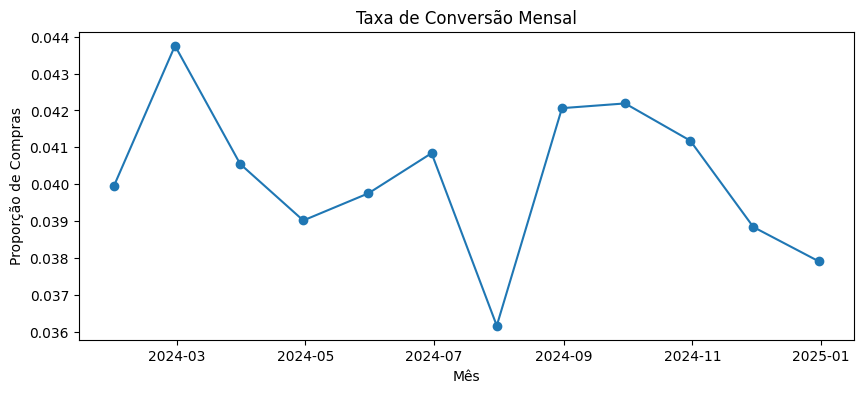

In [36]:
# Taxa de conversão mensal (purchase rate)
monthly_rate = df.set_index('timestamp').resample('M').purchase.mean()
plt.figure(figsize=(10,4))
plt.plot(monthly_rate.index, monthly_rate.values, marker='o')
plt.title('Taxa de Conversão Mensal')
plt.xlabel('Mês')
plt.ylabel('Proporção de Compras')
plt.show()

Com essa visualização é possível observar que a falta da relação entre compras nos períodos da black friday e do natal gerou uma inconsistência entre a relação do numéro de sessões e de compras.

#### 3.5 Top 10 produtos mais visitados
Identifica os 10 produtos com maior número de acessos, auxiliando na análise de popularidade de itens.

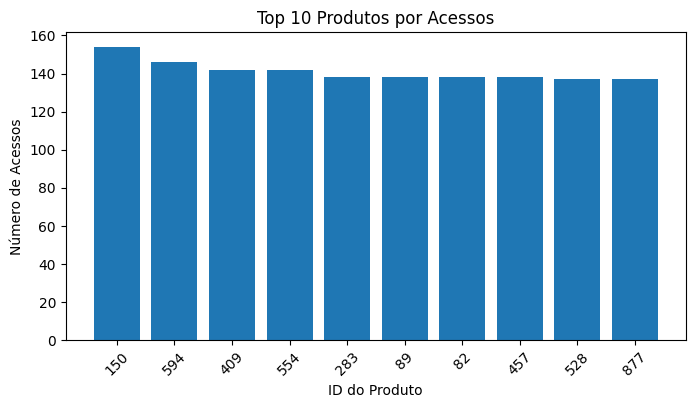

In [37]:
# Top 10 produtos por número de acessos
top10 = df['product_id'].value_counts().nlargest(10)
plt.figure(figsize=(8,4))
plt.bar(top10.index.astype(str), top10.values)
plt.title('Top 10 Produtos por Acessos')
plt.xlabel('ID do Produto')
plt.ylabel('Número de Acessos')
plt.xticks(rotation=45)
plt.show()

Como não houve a criação da relação entre itens e compras, a distribuição se manteve constante ao longo do top10, tendo poucas variações.

### Passo 4: Considerações Finais (2 pontos)
*Pontos positivos do DataFrame*
- Há a inserção de sazonalidade nos dias do Natal e Black Friday
- Há uma relação direta entre `add_to_cart` e `purchase`, de modo a trazer coerência aos dados, já que não há como realizar uma compra sem itens no carrinho
- Há a inserção de valores nulos para representar usuários não logados
- As distribuições escolhidas foram escolhidas para se parecer com a distribuição de dataframes reais


*Limitações do DataFrame*
- Não modela variações de comportamento por dia da semana (ex.: finais de semana vs dias úteis).
- Cada linha corresponde a um clique isolado, sem agrupar múltiplas páginas numa mesma sessão.
- A sazonalidade é simplificada e não leva em conta promoções específicas ou campanhas de marketing.
- Não há sequência lógica de navegação por produto ou recomendações; IDs são independentes e aleatórios.
